# Notebook for PCA of the data

## Libraries

In [112]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
from matplotlib import pyplot as plt
import random
random.seed(1)
from sklearn.preprocessing import normalize

## Importing the data set
Our dataset contains images of the **HAM10000** dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions.

In [94]:
# IMPORTANT: Filepath depends on OS!
inpath = r'data/hmnist_28_28_L.csv'
outpath = 'data/hmnist_28_28_L_pcaRed.csv'
df = pd.read_csv(inpath)
print(df) # Shape (#images, h*w+1) (here: (10015, 785))

       pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0            169        171        170        177        181        182   
1             19         57        105        140        149        148   
2            155        163        161        167        167        172   
3             25         71        116        139        136        153   
4            129        162        181        196        205        208   
...          ...        ...        ...        ...        ...        ...   
10010        172        171        173        175        164        187   
10011          2         34        108        116        114        119   
10012        122        154        162        170        179        197   
10013        137        143        141        139        147        152   
10014        149        157        157        152        151        152   

       pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel0775  pixel0776  \
0            181   

## Displaying a data image

In [113]:
def disp_img(data_vec):
    # Handle the cases of whether the label for an image is provided or not
    if math.sqrt(np.size(data_vec)) != int(math.sqrt(np.size(data_vec))):
        img_label = data_vec[-1]
        img_vec = data_vec[0:-1]
    else:
        img_vec = data_vec

    size = np.size(img_vec)
    dimension = int(math.sqrt(size))

    img_mat = np.reshape(np.array(img_vec), (dimension, dimension))

    plt.imshow(img_mat)
    plt.show()

# Count occurences of labels
Count the number of data images corresponding to each label.

In [114]:
# Each tuple will contain a label and the number of images with the same label
# [(label, #occurences), ..]
label = df['label']
uniq_label, counts_label = np.unique(label, return_counts=True)
occurences = list(zip(uniq_label, counts_label))

print(occurences)

[(0, 327), (1, 514), (2, 1099), (3, 115), (4, 6705), (5, 142), (6, 1113)]


# Importing metadata
This metadata file contains additional information about the patients for each data image (e.g. age, sex, body part where the image has been taken).

In [115]:
# IMPORTANT: Filepath depends on OS!
df_meta = pd.read_csv(r'data/HAM10000_metadata.csv')

print(df_meta)

         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


# The various diagnostic categories
The labels/numbers represent the following diagnostic categories:

**0)** Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)

**1)** basal cell carcinoma (bcc)

**2)** benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)

**3)** dermatofibroma (df)

**4)** melanoma (mel)

**5)** melanocytic nevi (nv)

**6)** vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)

In [116]:
cath = df_meta['dx']
uniq_cath, counts_cath = np.unique(cath, return_counts=True)
diagnoses = list(zip(uniq_cath, counts_cath))

print(diagnoses)

[('akiec', 327), ('bcc', 514), ('bkl', 1099), ('df', 115), ('mel', 1113), ('nv', 6705), ('vasc', 142)]


# Partition the images into the different classes
Create a list of nested lists. Each nested list represents a label and contains the indices of all data images with the same label. E.g. img_index_group[2] contains all images for label 2.

In [117]:
# List of 7 nested lists (for each diagnostical categorie)
# The ith nested list contains the indices of all images, which correspond to label i
# E.g. img_index_group[2] contains all images for label 2
img_index_group = []

for i in range(len(uniq_label)):
    img_index_group.append([])
    for j in range(df.shape[0]):
        if df['label'][j] == i:
            img_index_group[i].append(j)

print(img_index_group)

# For debugging purposes
# print(list((i, len(img_index_group[i])) for i in range(len(img_index_group))))

[[9687, 9688, 9689, 9690, 9691, 9692, 9693, 9694, 9695, 9696, 9697, 9698, 9699, 9700, 9701, 9702, 9703, 9704, 9705, 9706, 9707, 9708, 9709, 9710, 9711, 9712, 9713, 9714, 9715, 9716, 9717, 9718, 9719, 9720, 9721, 9722, 9723, 9724, 9725, 9726, 9727, 9728, 9729, 9730, 9731, 9732, 9733, 9734, 9735, 9736, 9737, 9738, 9739, 9740, 9741, 9742, 9743, 9744, 9745, 9746, 9747, 9748, 9749, 9750, 9751, 9752, 9753, 9754, 9755, 9756, 9757, 9758, 9759, 9760, 9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786, 9787, 9788, 9789, 9790, 9791, 9792, 9793, 9794, 9795, 9796, 9797, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9807, 9808, 9809, 9810, 9811, 9812, 9813, 9814, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9834, 9835, 9836, 9837, 9838, 9839, 9840, 9841, 9842, 9843, 9844, 9845, 9846, 9847, 9848, 9849, 9850, 9851, 9852, 98

# Splitting into training and testing data

In [118]:
training_split = 0.9                #Percentage of Data used for training
img_index_group_split = []          #Same as img_index_group but every nested list is split into two lists: first is list for training, second is list for testing

for i in range(len(img_index_group)):
    random.shuffle(img_index_group[i])
    split_point = round(len(img_index_group[i])*training_split)
    img_index_group_split.append([img_index_group[i][:split_point], img_index_group[i][split_point:]])
    
    #print(i)
    #print(len(img_index_group_split[i][0]))
    #print(len(img_index_group_split[i][1]))

#print(img_index_group_split)

# Running Clustering on the different diagnosis

## Principal Component Analysis

Corresponding to HW4 Question E, find reference for Steps in the posted Solution

### Discarding the labels of the data to create clean matrix for the calculations

In [101]:
data = df.iloc[:, :-1]
print(data)

       pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0            169        171        170        177        181        182   
1             19         57        105        140        149        148   
2            155        163        161        167        167        172   
3             25         71        116        139        136        153   
4            129        162        181        196        205        208   
...          ...        ...        ...        ...        ...        ...   
10010        172        171        173        175        164        187   
10011          2         34        108        116        114        119   
10012        122        154        162        170        179        197   
10013        137        143        141        139        147        152   
10014        149        157        157        152        151        152   

       pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel0774  pixel0775  \
0            181   

### Computing Mean of each diagnostics cathegory

Corresponding E.2

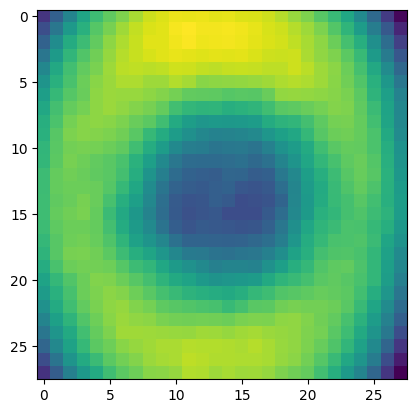

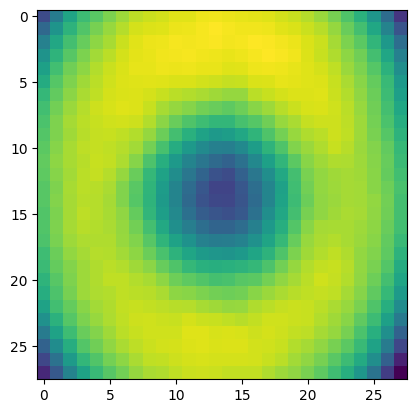

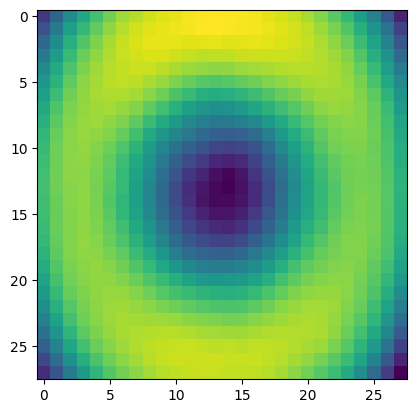

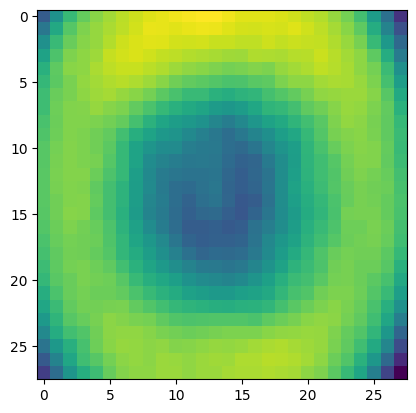

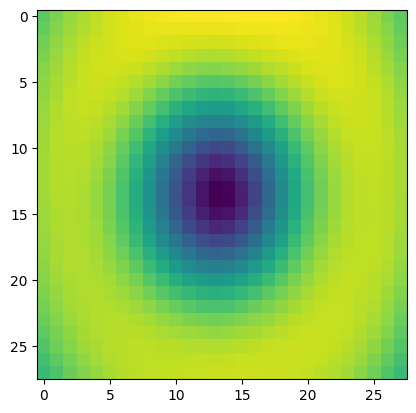

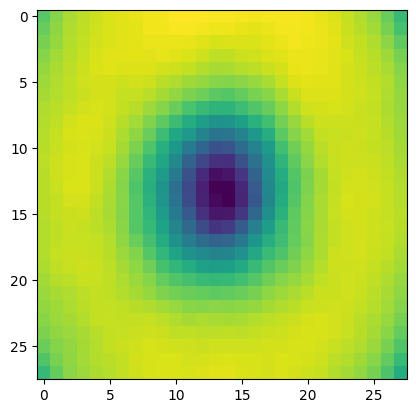

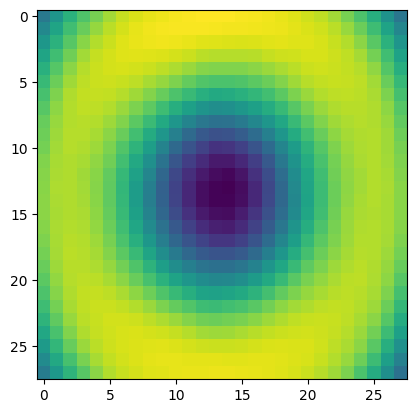

In [119]:
mean = []

for i in range(len(img_index_group)):
    mean.append(np.mean(data.iloc[img_index_group[i]], axis=0))
    
    disp_img(mean[i])
    #print(mean[i])

### Substracting Mean for each diagnostic cathegory from the data of that cathegory

Corresponding E.3

In [103]:
data_sub_mean = pd.DataFrame()
for i in range(len(img_index_group)):
    data_sub_mean = pd.concat((data_sub_mean, data.loc[img_index_group[i]]-mean[i]))

data_sub_mean.sort_index(axis=0, inplace=True)

#IMPORTANT
#In the lecture, data is in the form (#pixels X #images)
#For us its in the form (#images X #pixels), thats why sometimes there is a transpose when there is none in the VL
#See comments (transpose is because of different data shape) in next code blocks
#Isnt done globally because it messes up the indexing in the data frame which we need to fiter the images belonging to a group
#This is why nearly next to all data_sub_mean.loc[img_index_gour[i]] there will be an additional .transpose() which does not come up in tne formulas from lecture
#Alternatively you can use the excact same formulas as in the lecture and run

#data_sub_mean = data_sub_mean.transpose()

#before. This makes the visualisation and indexing a lot more difficult however so we choose to not do it that way.

print(data_sub_mean)

        pixel0000   pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0       41.955414   36.427662  28.083712  29.213831  28.392175  25.363967   
1     -108.044586  -77.572338 -36.916288  -7.786169  -3.607825  -8.636033   
2       27.955414   28.427662  19.083712  19.213831  14.392175  15.363967   
3     -102.044586  -63.572338 -25.916288  -8.786169 -16.607825  -3.636033   
4        1.955414   27.427662  39.083712  48.213831  52.392175  51.363967   
...           ...         ...        ...        ...        ...        ...   
10010   30.048930   22.428135  18.226300  14.296636  -1.149847  18.899083   
10011 -139.951070 -114.571865 -46.773700 -44.703364 -51.149847 -49.100917   
10012  -19.951070    5.428135   7.226300   9.296636  13.850153  28.899083   
10013   -4.951070   -5.571865 -13.773700 -21.703364 -18.149847 -16.100917   
10014   24.082659   22.716083  13.783468   2.057502  -4.674753  -8.734052   

       pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel0774  pixel077

### Calculating the Eigenvalues and Eigenvectores for each cathegory

Corresponding E.4

In [104]:
eig_vec = []
eig_val = []

for i in range(len(img_index_group)):
    matrix = data_sub_mean.loc[img_index_group[i]].transpose() #Last transpose is because of different data shape
    val, vec = np.linalg.eig(matrix.transpose().dot(matrix))
    eig_val.append(val)
    eig_vec.append(vec)

print(eig_val)
print(eig_vec)


[array([6.50774501e+07, 2.34687085e+07, 1.54681273e+07, 7.85415670e+06,
       6.41630418e+06, 4.76621781e+06, 4.22550353e+06, 3.98356738e+06,
       3.13270569e+06, 2.61939698e+06, 1.86409499e+06, 1.81382840e+06,
       1.68660688e+06, 1.53125803e+06, 1.46567484e+06, 1.32175500e+06,
       1.21896645e+06, 1.07275685e+06, 1.02179453e+06, 9.78382837e+05,
       9.17059354e+05, 8.11285481e+05, 7.87531435e+05, 7.68096204e+05,
       7.45919821e+05, 6.99716535e+05, 6.67475305e+05, 6.61096740e+05,
       6.14806716e+05, 5.65487422e+05, 5.07661563e+05, 4.90885005e+05,
       4.81283927e+05, 4.51611587e+05, 4.27554152e+05, 4.20214443e+05,
       4.03087043e+05, 3.88624714e+05, 3.67624801e+05, 3.49232837e+05,
       3.45633973e+05, 3.39006542e+05, 3.22657820e+05, 3.15754971e+05,
       3.13096689e+05, 3.00777878e+05, 2.89009408e+05, 2.81846357e+05,
       2.79519925e+05, 2.73231840e+05, 2.64896664e+05, 2.48404131e+05,
       2.41832547e+05, 6.54023505e-10, 2.30644402e+05, 2.24853841e+05,
     

### Sorting the Eigenvectors acording to the size of their corresponding Eigenvalues

Corresponding E.5

In [105]:
for i in range(len(img_index_group)):
    idx = eig_val[i].argsort()[::-1]
    eig_val[i] = eig_val[i][idx]
    eig_vec[i] = eig_vec[i][:, idx]

## Finishing Calculation and normalization of real EV 

Corresponding E.6 and E.7

NOTE: The calculation is complex for some EV and EW of some cathegories while it should be real

Can be partially solved by casting comp as real since just the last few are complex and are not used in the reconstruction of the images anyway, however this is far from an ideal solution. The mapping to the absolute length of the vector in the real space does not provide correct solutions.

In [106]:
eig = []

for i in range(len(img_index_group)):
    eig_cath = data_sub_mean.loc[img_index_group[i]].transpose().dot(eig_vec[i]) #transpose is because of different data shape
    eig_cath = eig_cath.astype(np.float64) #applymap(np.absolute)
    eig.append(normalize(eig_cath, norm='l2', axis=0))

print(eig_cath)

c:\Users\luisw\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
c:\Users\luisw\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


                  0           1           2           3          4     \
pixel0000  1424.586721  626.620460  731.041900 -345.817350  57.333478   
pixel0001  1404.178898  567.885003  692.399375 -350.368018  61.566450   
pixel0002  1321.716308  500.020533  610.838215 -301.818039  59.816198   
pixel0003  1217.401715  433.855217  507.663326 -244.274310  65.412214   
pixel0004  1093.968730  347.662440  374.482049 -184.356390  93.248788   
...                ...         ...         ...         ...        ...   
pixel0779   961.724568  299.825836  128.332242   78.500123 -36.143944   
pixel0780  1150.737619  430.806368  288.684516   11.592931 -44.975326   
pixel0781  1294.978627  560.850760  440.087256  -46.327394 -48.909089   
pixel0782  1382.114281  688.512562  540.816044  -74.807280 -46.822204   
pixel0783  1423.713090  780.902091  585.615390  -70.743979 -37.927959   

                 5           6          7           8           9     ...  \
pixel0000  469.180287 -382.374580 -16.539377 -

c:\Users\luisw\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


## Calculating of Principal Components C

Corresponding to F

In [ ]:
C = []
for i in range(len(img_index_group)):
    C.append(eig[i].transpose().dot(data_sub_mean.loc[img_index_group[i]].transpose()).transpose()) 
    #Second to last transpose is because of different data shape

## Reconstructing the Images with the calculated Principal Components

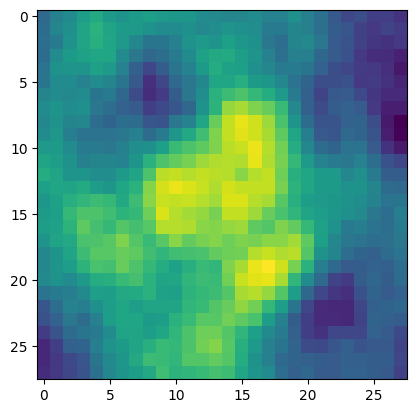

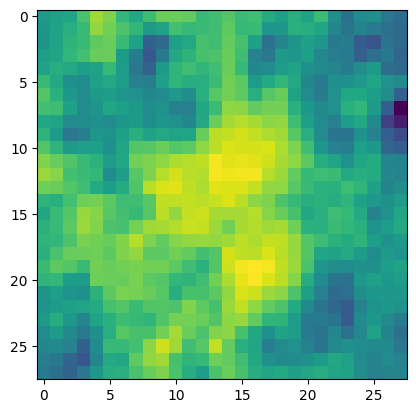

In [121]:
df_pca = df.copy()

img_idx = 0
cath_idx = 0
compression_factor = 0.9 

for i in range(len(img_index_group)):
    num_pca = round(len(C[i])*compression_factor)
    for j in range(len(img_index_group[i])):
        z = eig[i][:, :-num_pca].dot(C[i][j][:-num_pca]) + mean[i]
        df_pca.loc[img_index_group[i][j]].iloc[:-1] = z.astype(np.int64)

#Displaying one PCA Reconstructed Image using 1-compression_factor PC to reconstruct and the original image
disp_img(df_pca.loc[img_index_group[cath_idx][img_idx]])
disp_img(data.iloc[img_index_group[cath_idx]].iloc[img_idx])


## Saving the Reconstructed Images to a CSV File

In [111]:
df_pca.to_csv(outpath, index=False)